# ReAct(Reasoning + Acting)
* 추론과 행동을 결합한 접근 방식

In [26]:
from dotenv import load_dotenv

load_dotenv()

True

In [27]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")

In [28]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.tools import tool
from typing import List

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Chroma 인덱스 로드
vector_db = Chroma(
    embedding_function=embeddings_model,
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

# Tool 정의
@tool
def search_menu(query: str) -> List[str]:
    """레스토랑 메뉴에서 정보를 검색합니다."""
    docs = vector_db.similarity_search(query, k=2)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs

    return "관련 메뉴 정보를 찾을 수 없습니다."

In [29]:
from langchain_community.tools import TavilySearchResults


# Tool 정의
@tool
def search_web(query: str) -> List[str]:
    """데이터베이스에 존재하지 않는 정보 또는 최신 정보를 인터넷에서 검색합니다."""

    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs

    return "관련 정보를 찾을 수 없습니다."

In [30]:
from langchain_openai import ChatOpenAI

# LLM 모델
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)

# 도구 목록
tools = [search_menu, search_web]

# 모델에 도구를 바인딩
llm_with_tools = llm.bind_tools(tools=tools)

In [31]:
from langchain_core.messages import HumanMessage

# 도구 호출
tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

# 결과 출력
print(tool_call.additional_kwargs)

{'tool_calls': [{'index': 0, 'id': 'call_OsJZCKlLFJmgWjWDtbvyjJOG', 'function': {'arguments': '{"query":"스테이크"}', 'name': 'search_menu'}, 'type': 'function'}]}


In [32]:
# 도구 호출
ai_msg = llm_with_tools.invoke([HumanMessage(content=f"3+3은 얼마인가요?")])

# 결과 출력
print(ai_msg.additional_kwargs)

{}


In [33]:
# 도구 호출
ai_msg = llm_with_tools.invoke([HumanMessage(content=f"LangGraph는 무엇인가요?")])

# 결과 출력
print(ai_msg)


content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_WBOioSySOIojLjYiR0OtkGk6', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'search_web'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'} id='run--1637a336-cc84-40ac-8c36-082fc96ceb35-0' tool_calls=[{'name': 'search_web', 'args': {'query': 'LangGraph'}, 'id': 'call_WBOioSySOIojLjYiR0OtkGk6', 'type': 'tool_call'}]


In [34]:
for tool_call in ai_msg.tool_calls:
    print(f"{tool_call['name']}: \n{tool_call}")
    print("-"*100)

    tool_message = None
    if tool_call["name"] == "search_menu":
        tool_message = search_menu.invoke(tool_call)
    if tool_call["name"] == "search_web":
        tool_message = search_web.invoke(tool_call)
    print(tool_message.content)


search_web: 
{'name': 'search_web', 'args': {'query': 'LangGraph'}, 'id': 'call_WBOioSySOIojLjYiR0OtkGk6', 'type': 'tool_call'}
----------------------------------------------------------------------------------------------------
<Document href="https://www.ibm.com/think/topics/langgraph"/>
LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. [...] Agent systems: LangGraph provides a framework for building agent-based systems, which can be used in applications such as robotics, autonomous vehicles or video games.

LLM applications: By using LangGraph’s capabilities, developers can b

In [35]:
ai_msg

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_WBOioSySOIojLjYiR0OtkGk6', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'}, id='run--1637a336-cc84-40ac-8c36-082fc96ceb35-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'LangGraph'}, 'id': 'call_WBOioSySOIojLjYiR0OtkGk6', 'type': 'tool_call'}])

## 도구 노드
- LLM이 요청한 도구들을 병렬로 실행

In [36]:
from langgraph.prebuilt import ToolNode

# 도구 노드 정의
tool_node = ToolNode(tools=tools)

In [37]:
# 도구 호출
ai_msg = llm_with_tools.invoke([HumanMessage(content=f"LangGraph는 무엇인가요?")])

ai_msg

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_A9756yhY4H4R6Vy552UeKGNS', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'}, id='run--63b279a9-f0a6-498b-99cd-7654adaf2460-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'LangGraph'}, 'id': 'call_A9756yhY4H4R6Vy552UeKGNS', 'type': 'tool_call'}])

In [38]:
# 도구 호출 결과를 메시지로 추가하여 실행
results = tool_node.invoke({"messages": [ai_msg]})

# 실행 결과 출력하여 확인
for result in results['messages']:
    print(result.content)
    print()

<Document href="https://www.ibm.com/think/topics/langgraph"/>
LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. [...] Agent systems: LangGraph provides a framework for building agent-based systems, which can be used in applications such as robotics, autonomous vehicles or video games.

LLM applications: By using LangGraph’s capabilities, developers can build more sophisticated AI models that learn and improve over time. Norwegian Cruise Line uses LangGraph to compile, construct and refine guest-facing AI solutions. This capability allows for improved and personalized guest exper

## 랭그래프에 내장된 ReAct 에이전트 사용
- create_react_agent
    - v0.1 이후 AgentExecutor로 감사지 않아도 됨
- AgentExecutor는 왜 남아있을까?
| 경우                 | 설명                                          |
| ------------------ | ------------------------------------------- |
| 🔧 **커스텀 에이전트**    | 직접 만든 Agent 클래스를 실행할 때 (예: ZeroShotAgent 등) |
| 🔄 **호환성**         | 구버전 LangChain 코드와의 호환성                      |
| 🔍 **디버깅 및 세부 제어** | 중간 단계 추적, 로깅, callback 설정 등                 |
| 🧩 **유연한 도구 처리**   | 여러 Agent나 chain을 묶어 실행하는 복잡한 구조 만들 때        |

![](images/create_react_agent.png)

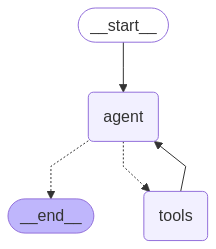

In [39]:
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent
agent_graph = create_react_agent(
    llm,
    tools=tools,
)

# 그래프 출력
agent_graph

In [40]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = agent_graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_YkbQN4bCW3vf0K3kzRrZFzYc)
 Call ID: call_YkbQN4bCW3vf0K3kzRrZFzYc
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
</Document>
================================== Ai Message ==================================

스테이크 메뉴는 

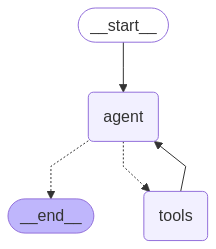

In [41]:
from langgraph.prebuilt import create_react_agent

# 시스템 프롬프트
system_prompt = dedent("""
You are an AI assistant designed to answer human questions.
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크

    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니다...

    Action: search_web
    Action Input: History of AI

    (After receiving tool output)
    [Source: search_web | AI History | https://en.wikipedia.org/wiki/History_of_artificial_intelligence]
    AI의 역사는 다음과 같이 요약됩니다...

If tool use is not necessary, answer directly.

Your final answer should be clear, concise, and directly related to the user's question.
Ensure that every piece of factual information in your response is accompanied by a citation.

Remember: ALWAYS include these citations for all factual information, tool outputs, and referenced documents in your response.
Do not provide any information without a corresponding citation.
""")

# 그래프 생성
agent_graph_with_prompt = create_react_agent(
    llm,
    tools=tools,
    state_modifier=system_prompt,
    )

# 그래프 출력
agent_graph_with_prompt


In [42]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = agent_graph_with_prompt.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_RDSizDeeB86tRFTmmyGpOloF)
 Call ID: call_RDSizDeeB86tRFTmmyGpOloF
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
</Document>
================================== Ai Message ==================================

스테이크 메뉴의 

## StateGraph 구조를 사용하여 ReAct 에이전트 만들기
### StateGraph를 이용해서 create_react_agent와 같은 구조 만들기
- ![](images/custom_react_agent.png)

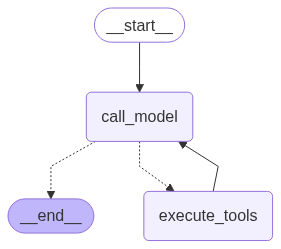

In [43]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# LangGraph MessagesState 사용
class GraphState(MessagesState):
    pass

# 노드 구성
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: GraphState):
    last_message = state["messages"][-1]
    # 도구 호출이 있으면 도구 실행 노드로 이동
    if last_message.tool_calls:
        return "execute_tools"
    # 도구 호출이 없으면 답변 생성하고 종료
    return END

# 그래프 구성
builder = StateGraph(GraphState)
builder.add_node("call_model", call_model)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model",
    should_continue,
    {
        "execute_tools": "execute_tools",
        END: END
    }
)
builder.add_edge("execute_tools", "call_model")

compiled_graph = builder.compile()

# 그래프 출력
compiled_graph

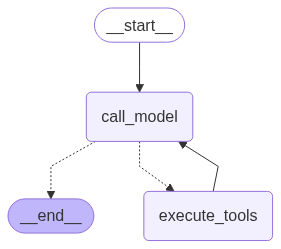

In [44]:
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [45]:
compiled_graph.get_graph().draw_mermaid()

'---\nconfig:\n  flowchart:\n    curve: linear\n---\ngraph TD;\n\t__start__([<p>__start__</p>]):::first\n\tcall_model(call_model)\n\texecute_tools(execute_tools)\n\t__end__([<p>__end__</p>]):::last\n\t__start__ --> call_model;\n\tcall_model -.-> __end__;\n\tcall_model -.-> execute_tools;\n\texecute_tools --> call_model;\n\tclassDef default fill:#f2f0ff,line-height:1.2\n\tclassDef first fill-opacity:0\n\tclassDef last fill:#bfb6fc\n'

In [72]:
def graph_to_mermaid(graph) -> str:
    """
    주어진 graph 객체를 Mermaid 형식 문자열로 변환합니다.
    LangGraph 0.4.5 버전에 맞춰 작성되었습니다.
    Parameters:
        graph: 노드와 엣지를 포함한 그래프 객체.
               graph.nodes와 graph.edges를 가져올 수 있어야 하며,
               각 edge는 source, target 속성을 가져야 합니다.
    Returns:
        Mermaid 형식 문자열
    """
    nodes = graph.nodes
    edges = graph.edges
    mermaid = ["graph TD"]

    # 조건부 엣지 그룹핑을 위한 딕셔너리
    conditional_groups = {}
    normal_edges = []

    # 엣지를 분류
    for edge in edges:
        source = edge.source
        target = edge.target

        # LangGraph 0.4.5에서 조건부 엣지 확인
        has_condition = False
        condition_name = None

        # 조건부 엣지는 보통 같은 source에서 여러 target으로 가는 패턴
        # 또는 edge.data에 조건 정보가 포함됨
        if hasattr(edge, 'data') and edge.data:
            if isinstance(edge.data, dict):
                # 조건 함수나 조건 정보 확인
                if 'condition' in edge.data and callable(edge.data['condition']):
                    has_condition = True
                    condition_name = getattr(edge.data['condition'], '__name__', 'condition')
                elif 'branch' in edge.data:
                    # branch 정보에서 조건 함수 이름 추출
                    branch_info = edge.data['branch']
                    if callable(branch_info):
                        has_condition = True
                        condition_name = getattr(branch_info, '__name__', 'condition')
                    elif isinstance(branch_info, str):
                        has_condition = True
                        condition_name = branch_info
                # add_additional_edge도 조건부 엣지로 처리
                elif edge.data.get('langgraph_node') == '__interrupt':
                    has_condition = True
                    condition_name = 'additional_condition'

        # edge 자체에 조건 정보가 있는지 확인
        if not has_condition:
            # 같은 source에서 나가는 여러 엣지가 있는지 확인하여 조건부 엣지 추정
            source_edges = [e for e in edges if e.source == source]
            if len(source_edges) > 1:
                # 여러 엣지가 있고 특별한 패턴(예: __end__나 특정 노드로 가는)이 있으면 조건부로 간주
                targets = [e.target for e in source_edges]
                if '__end__' in targets or len(set(targets)) > 1:
                    has_condition = True
                    # 기본 조건 이름을 source 기반으로 추정 (예: call_model -> should_continue)
                    if source == 'call_model':
                        condition_name = 'should_continue'
                    else:
                        condition_name = f"{source}_condition"

        # 조건부 엣지 그룹핑
        if has_condition:
            group_key = f"{source}_{condition_name}"
            if group_key not in conditional_groups:
                conditional_groups[group_key] = {
                    'source': source,
                    'condition_name': condition_name,
                    'targets': []
                }

            # 라벨 정보 추출 (조건 결과 키 값)
            label = None
            if hasattr(edge, 'data') and edge.data and isinstance(edge.data, dict):
                # 조건 매핑에서 키 값을 찾아서 라벨로 사용
                for key, value in edge.data.items():
                    if value == target or (isinstance(value, str) and value == target):
                        label = key
                        break
                # 또는 직접 label 속성이 있는 경우
                if not label:
                    label = edge.data.get('label', None)

            # 특별한 경우 처리 (END 노드)
            if target in ['__end__', 'END'] and not label:
                label = "END"
            elif not label:
                # 기본적으로 타겟 노드 이름을 라벨로 사용
                label = target.replace('__', '').upper() if target.startswith('__') else target

            conditional_groups[group_key]['targets'].append({
                'target': target,
                'label': label
            })
        else:
            normal_edges.append(edge)
    # 헬퍼 함수: 노드 이름 변환
    def get_node_name(node):
        if node == '__start__':
            return 'START'
        elif node == '__end__':
            return 'END'
        return node
    # 일반 노드 추가
    for node in nodes:
        if node not in ['__start__', '__end__']:  # 특수 노드 제외
            mermaid.append(f'{node}["{node}"]')
        else:
            # START, END 노드는 특별한 모양으로
            if node == '__start__':
                mermaid.append(f'START(("START"))')
            elif node == '__end__':
                mermaid.append(f'END(("END"))')

    # 조건부 엣지 노드들 추가
    for group_key, group_info in conditional_groups.items():
        condition_id = f"cond_{group_info['source']}_{group_info['condition_name']}"
        # 조건 함수 이름을 다이아몬드 노드에 표시
        mermaid.append(f'{condition_id}([{group_info["condition_name"]}])')
        mermaid.append(f'classDef conditionalNode fill:#e1f5fe,stroke:#01579b,stroke-width:2px')
        mermaid.append(f'class {condition_id} conditionalNode')

        # 소스 노드에서 조건 노드로
        source_node = get_node_name(group_info['source'])
        mermaid.append(f"{source_node} --> {condition_id}")

        # 조건 노드에서 각 타겟으로 분기 (점선으로 표시)
        for target_info in group_info['targets']:
            target_node = get_node_name(target_info['target'])
            edge_label = target_info['label'] if target_info['label'] else ("END" if target_node == 'END' else target_node)
            mermaid.append(f"{condition_id} -.->|{edge_label}| {target_node}")

    # 일반 엣지 추가
    for edge in normal_edges:
        source = edge.source
        target = edge.target

        # 특수 노드 변환
        source_node = source if source not in ['__start__', '__end__'] else ('START' if source == '__start__' else 'END')
        target_node = target if target not in ['__start__', '__end__'] else ('START' if target == '__start__' else 'END')

        # 라벨 확인
        label = None
        if hasattr(edge, 'data') and edge.data and isinstance(edge.data, dict):
            label = edge.data.get('label', None)

        if label and label != target:
            mermaid.append(f"{source_node} -->|{label}| {target_node}")
        else:
            mermaid.append(f"{source_node} --> {target_node}")

    return "\n".join(mermaid)

# 사용 예시
graph = compiled_graph.get_graph()
graph_mermaid_str = graph_to_mermaid(graph)
print(graph_mermaid_str)

graph TD
START(("START"))
call_model["call_model"]
execute_tools["execute_tools"]
END(("END"))
cond_call_model_should_continue([should_continue])
classDef conditionalNode fill:#e1f5fe,stroke:#01579b,stroke-width:2px
class cond_call_model_should_continue conditionalNode
call_model --> cond_call_model_should_continue
cond_call_model_should_continue -.->|END| END
cond_call_model_should_continue -.->|execute_tools| execute_tools
START --> call_model
execute_tools --> call_model


In [73]:
from IPython.display import HTML
import uuid

def simple_mermaid_render(mermaid_code):
    """외부 패키지 없이 Mermaid 렌더링"""
    chart_id = f"chart-{uuid.uuid4().hex[:8]}"
    html = f"""
    <div id="{chart_id}" class="mermaid">
    {mermaid_code}
    </div>
    <script type="module">
        import mermaid from 'https://cdn.jsdelivr.net/npm/mermaid@10/dist/mermaid.esm.min.mjs';
        mermaid.initialize({{
            startOnLoad: true,
            theme: 'default',
            flowchart: {{
                useMaxWidth: true,
                htmlLabels: true
            }}
        }});
        mermaid.init(undefined, document.getElementById('{chart_id}'));
    </script>
    """
    return HTML(html)
simple_mermaid_render(graph_mermaid_str)

In [48]:
def render_graph(graph):
    """
    그래프 객체를 받아 Mermaid로 렌더링합니다.
    """
    mermaid_code = graph_to_mermaid(graph)
    return simple_mermaid_render(mermaid_code)
graph = compiled_graph.get_graph()
render_graph(graph)

In [19]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_bOI9L14dR1Op3aaIUnHKL5UF)
 Call ID: call_bOI9L14dR1Op3aaIUnHKL5UF
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
</Document>
================================== Ai Message ==================================

스테이크 메뉴의 

### tools_condiction 함수 이용하여 create_react_agent와 같은 구조 만들기
- ![](images/tools_condition.png)

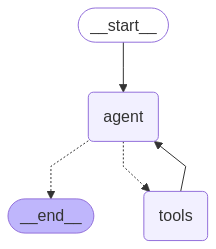

In [20]:
from langgraph.prebuilt import tools_condition

# 노드 함수 정의
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

graph = builder.compile()

# 그래프 출력
graph

In [21]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="파스타에 어울리는 음료는 무엇인가요?")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

파스타에 어울리는 음료는 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_rgJM4LFMFpvAtIapN5pd31Kk)
 Call ID: call_rgJM4LFMFpvAtIapN5pd31Kk
  Args:
    query: 파스타 음료 추천
  search_web (call_2L2XoXAlMXCTPbaH7qsy0Efe)
 Call ID: call_2L2XoXAlMXCTPbaH7qsy0Efe
  Args:
    query: 음식과 어울리는 음료 추천
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
4. 버섯 크림 수프
   • 가격: ₩10,000
   • 주요 식재료: 양송이버섯, 표고버섯, 생크림, 트러플 오일
   • 설명: 양송이버섯과 표고버섯을 오랜 시간 정성스레 끓여 만든 크림 수프입니다. 부드러운 텍스처와 깊은 버섯 향이 특징이며, 최상급 트러플 오일을 살짝 뿌려 고급스

## MemorySaver
### MemorySaver와 MessageState와의 차이점
* MemorySaver
- MemorySaver는 대화 기록을 외부 저장소에 영구적으로 저장하는 역할을 합니다.
- **주요 용도**: 대화 이력의 영구 저장 및 검색
- **특징**:
  - 다양한 백엔드 저장소(데이터베이스, 파일 시스템 등)와 통합 가능
  - 대화 히스토리를 세션 간에도 유지할 수 있음
  - 대화 이력을 장기간 보존하여 나중에 분석하거나 재사용할 수 있음
  - 일반적으로 시스템 수준의 저장소와 연결됨

* MessageState
- MessageState는 현재 실행 중인 대화 그래프의 컨텍스트 내에서 메시지를 관리합니다.
- **주요 용도**: 대화 흐름 내 메시지 상태 관리
- **특징**:
  - 그래프 실행 컨텍스트 내에서 메시지 상태를 관리
  - 주로 단일 세션 또는 대화 흐름 내에서 작동
  - 대화 컨텍스트를 유지하면서 노드 간에 메시지를 전달
  - 주로 메모리에 존재하며 대화 그래프 실행 중에만 유효함

* 주요 차이점
1. **범위**: MessageState는 현재 실행 중인 그래프 내에서 작동하는 반면, MemorySaver는 그래프 실행을 넘어서 데이터를 유지합니다.
2. **지속성**: MessageState는 임시적(in-memory)인 반면, MemorySaver는 영구적 저장을 목적으로 합니다.
3. **사용 목적**: MessageState는 대화 흐름 제어에 초점을 맞춘 반면, MemorySaver는 대화 이력의 보존과 검색에 중점을 둡니다.

> 실제 애플리케이션에서는 두 가지를 함께 사용하는 경우가 많습니다. MessageState로 현재 대화 흐름을 관리하면서, MemorySaver를 통해 중요한 대화 내용을 영구적으로 저장하는 방식입니다.

In [22]:
# 그래프 실행 - 이전 대화 내용을 기억하는지 못하는 문제가 있음
inputs = {"messages": [HumanMessage(content="이 중에 하나만 추천해주세요.")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

이 중에 하나만 추천해주세요.
================================== Ai Message ==================================

추천할 항목을 알려주시면, 해당 정보에 대해 조사하거나 추천할 수 있도록 도와드리겠습니다. 어떤 목록에서 하나를 추천받고 싶으신가요?


In [23]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 초기화
memory = MemorySaver()

# 체크포인터 지정하여 그래프 컴파일
graph_memory = builder.compile(checkpointer=memory)

In [24]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_jNG54pLVPJjK2uBPF5p3iyyr)
 Call ID: call_jNG54pLVPJjK2uBPF5p3iyyr
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
</Document>
================================== Ai Message ==================================

스테이크 메뉴 중

In [25]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="둘 중에 더 저렴한 메뉴는 무엇인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_jNG54pLVPJjK2uBPF5p3iyyr)
 Call ID: call_jNG54pLVPJjK2uBPF5p3iyyr
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습니다. 작은 랍스터 살을 토핑으로 올려 고급스러움을 더했습니다.
</Document>
================================== Ai Message ==================================

스테이크 메뉴 중

### 내장 ReAct에 반영

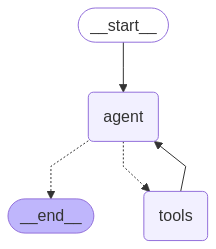

In [26]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

# 메모리 초기화
memory = MemorySaver()

# 그래프 생성
graph = create_react_agent(
    llm,
    tools=tools,
    state_modifier=system_prompt,
    checkpointer=memory,
    )

# 그래프 출력
graph

In [27]:
config = {"configurable": {"thread_id": "2"}}
messages = [HumanMessage(content="채식주의자를 위한 메뉴가 있나요?")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

채식주의자를 위한 메뉴가 있나요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_hE5miGxccONuTXK1dfdgxdMb)
 Call ID: call_hE5miGxccONuTXK1dfdgxdMb
  Args:
    query: 채식주의자 메뉴
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
9. 치킨 콘피
   • 가격: ₩23,000
   • 주요 식재료: 닭다리살, 허브, 마늘, 올리브 오일
   • 설명: 닭다리살을 허브와 마늘을 넣은 올리브 오일에 저온에서 장시간 조리한 프랑스 요리입니다. 부드럽고 촉촉한 육질이 특징이며, 로즈메리 감자와 제철 채소를 곁들여 제공합니다. 레몬 제스트를 뿌려 상큼한 향을 더했습니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
3. 연어 타르타르
   • 가격: ₩18,000
   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파
   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도, 케이퍼, 적양파와 함께 섞어 만든 타르타르입니다. 레몬 드레싱으로 상큼한 맛을 더했으며, 바삭한 브리오쉬 토스트와 함께 제공됩니다. 전채요리로 완벽한 메뉴입니다.
</Document>
================================== Ai Message ==================================

현

In [28]:
config = {"configurable": {"thread_id": "2"}}
messages = [HumanMessage(content="방금 답변에 대한 출처가 있나요?")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

채식주의자를 위한 메뉴가 있나요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_hE5miGxccONuTXK1dfdgxdMb)
 Call ID: call_hE5miGxccONuTXK1dfdgxdMb
  Args:
    query: 채식주의자 메뉴
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
9. 치킨 콘피
   • 가격: ₩23,000
   • 주요 식재료: 닭다리살, 허브, 마늘, 올리브 오일
   • 설명: 닭다리살을 허브와 마늘을 넣은 올리브 오일에 저온에서 장시간 조리한 프랑스 요리입니다. 부드럽고 촉촉한 육질이 특징이며, 로즈메리 감자와 제철 채소를 곁들여 제공합니다. 레몬 제스트를 뿌려 상큼한 향을 더했습니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
3. 연어 타르타르
   • 가격: ₩18,000
   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파
   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도, 케이퍼, 적양파와 함께 섞어 만든 타르타르입니다. 레몬 드레싱으로 상큼한 맛을 더했으며, 바삭한 브리오쉬 토스트와 함께 제공됩니다. 전채요리로 완벽한 메뉴입니다.
</Document>
================================== Ai Message ==================================

현